# Exploración de los algoritmos de asociación

### Objetivo

El presente notebook tiene como objetivo explorar los datos preparados por el anterior (1_eda) usando los algoritmos de Apriori y FP Growth vistos en el curso. El resultado de esta exploración será para elegir el algoritmo a aplicar finalmente.


### Algoritmos

#### Algoritmo Apriori

El algoritmo Apriori, propuesto por Agrawal y Srikant en 1994, es uno de los más utilizados para la generación de reglas de asociación a partir de bases de datos que contengan transacciones.

El algoritmo Apriori utiliza un enfoque bottom up. Partiendo de los conjuntos de artículos más pequeños, mediante un proceso iterativo, se van combinando estos conjuntos hasta que se llega a un límite fijado previamente. Posteriormente se procede a la construcción de las reglas de asociación utilizando únicamente los conjuntos de datos creados en el paso anterior.

#### Algoritmo FP-Growth
El algoritmo FP-Growth ha sido propuesto por Jiawei Han, Jian Pei y Yiwen Yin en el año 2000. En su diseño se ha tenido en cuenta que recorrer la base de datos varias veces para contar los registros, como se hace en el Apriori, no es una forma eficiente de buscar la lista de candidatos para las reglas. Con la idea de evitar esta búsqueda se propuso la utilización de un árbol en el que se almacena la información necesaria para obtener el soporte de los conjuntos de artículos candidatos.

Los pasos que se deben seguir para la implementación de FP-Growth son los siguientes:

1. Al igual que en el Apriori, se cuenta el número de apariciones de todos los artículos, seleccionando únicamente los que superen un valor de soporte mínimo.
2. Los artículos seleccionados en el paso anterior se ordenan en función del número de apariciones que tienen en el conjunto de datos.
3. Se construye un árbol con el orden del paso anterior y se procede a añadir los registros de la base de datos, ordenándolos con los resultados del paso 2.
4. Para seleccionar una regla se ha de recorrer el árbol y parar cuando ya no se supere el umbral necesario.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

### Cargar el dataset

In [2]:
orders = pd.read_csv('C:/Users/josefina.lin/Documents/Master/10-Trabajo Final/datasets/model_input.csv')

In [3]:
orders.sample(5)

,StockCode,Description,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
244564,20802,SMALL GLASS SUNDAE DISH CLEAR,539250,72,2010-12-16 13:44:00,0.42,15157.0,United Kingdom
47147,22941,CHRISTMAS LIGHTS 10 REINDEER,575856,1,2011-11-11 12:28:00,8.50,16386.0,United Kingdom
338199,23661,MILK MAIDS MUG,571230,12,2011-10-14 14:16:00,1.65,13717.0,United Kingdom
166289,21509,COWBOYS AND INDIANS BIRTHDAY CARD,572838,12,2011-10-26 12:03:00,0.42,14539.0,United Kingdom
291297,23255,CHILDRENS CUTLERY CIRCUS PARADE,579196,1,2011-11-28 15:54:00,8.29,14096.0,United Kingdom


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361763 entries, 0 to 361762
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   StockCode    361763 non-null  object 
 1   Description  361763 non-null  object 
 2   InvoiceNo    361763 non-null  object 
 3   Quantity     361763 non-null  int64  
 4   InvoiceDate  361763 non-null  object 
 5   UnitPrice    361763 non-null  float64
 6   CustomerID   340989 non-null  float64
 7   Country      361763 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 22.1+ MB


In [5]:
orders.drop(["CustomerID","Quantity","UnitPrice","InvoiceDate"],
            axis=1,
            inplace=True)

### Inspeccionar la data

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361763 entries, 0 to 361762
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   StockCode    361763 non-null  object
 1   Description  361763 non-null  object
 2   InvoiceNo    361763 non-null  object
 3   Country      361763 non-null  object
dtypes: object(4)
memory usage: 11.0+ MB


In [7]:
### Identificamos las columnas que son categóricas

CATEGORICAL_COLUMNS = ['InvoiceNo',
                       'StockCode',
                       'Description', 
                       'Country'
                      ]
orders[CATEGORICAL_COLUMNS] = orders[CATEGORICAL_COLUMNS].astype('object')

En este dataset encontramos 17549 órdenes diferentes del país United Kingdom. En total se compraron 3774 productos diferentes. El producto más comprado `WHITE HANGING HEART T-LIGHT HOLDER`.

In [8]:
orders[CATEGORICAL_COLUMNS].describe()

,InvoiceNo,StockCode,Description,Country
count,361763,361763,361763,361763
unique,17549,3774,3669,1
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,519,1960,1993,361763


### Preparación de los datos

In [9]:
# Generamos una lista de lista para todas nuestras transacciones

all_transactions = [transaction[1]['Description'].tolist() 
                    for transaction 
                    in list(orders.groupby(['InvoiceNo']))]

C:\Users\josefina.lin\AppData\Local\Temp\ipykernel_21068\827151519.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  in list(orders.groupby(['InvoiceNo']))]


Necesitamos transformar nuestro dataset de tal forma de tener una matriz cuyas columnas contienen todos los productos disponibles en el país y las filas son todas las órdenes. Se marcará en cada caso si en esa órden se compró o no cada producto.

In [10]:
# Miramos las primeras 10 transacciones
all_transactions[0:10]

[['GLASS STAR FROSTED T-LIGHT HOLDER',
  'SET 7 BABUSHKA NESTING BOXES',
  'RED WOOLLY HOTTIE WHITE HEART.',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  'CREAM CUPID HEARTS COAT HANGER',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  'WHITE METAL LANTERN'],
 ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'],
 ['HOME BUILDING BLOCK WORD',
  'LOVE BUILDING BLOCK WORD',
  'RECIPE BOX WITH METAL HEART',
  'IVORY KNITTED MUG COSY ',
  'BOX OF VINTAGE ALPHABET BLOCKS',
  'BOX OF VINTAGE JIGSAW BLOCKS ',
  "POPPY'S PLAYHOUSE BEDROOM ",
  "POPPY'S PLAYHOUSE KITCHEN",
  'FELTCRAFT PRINCESS CHARLOTTE DOLL',
  'DOORMAT NEW ENGLAND',
  'ASSORTED COLOUR BIRD ORNAMENT',
  'BOX OF 6 ASSORTED COLOUR TEASPOONS'],
 ['YELLOW COAT RACK PARIS FASHION',
  'RED COAT RACK PARIS FASHION',
  'BLUE COAT RACK PARIS FASHION',
  'JAM MAKING SET WITH JARS'],
 ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'],
 ['GLASS STAR FROSTED T-LIGHT HOLDER',
  'SET 7 BABUSHKA NESTING BOXES',
  'RED WOOLLY HOTTIE WHITE HE

In [11]:
# TransactionEncoder nos permite transformar nuestro dataset tal como lo precisamos

trans_encoder = TransactionEncoder() # Instanciate the encoder
trans_encoder_matrix = trans_encoder.fit(all_transactions).transform(all_transactions)
trans_encoder_matrix = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_)

In [12]:
trans_encoder_matrix.head()

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,...,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
trans_encoder_matrix.shape

(17549, 3669)

## Implementación de las Reglas de Asociación

A continuación se definirán funciones para la implementación de las reglas de asociación.

El __soporte__ indica qué tan popular es un artículo, es decir, cuán frecuente aparece en las compras. El umbral lo tenemos que determinar nostotros, por ejemplo, si lo seteamos en .5 entonces nos quedaremos solo con aquellos que ocurren juntos por lo menos el 5% de las veces. Cuanto más bajo sea mayor combinaciones de artículos lograremos y por lo tanto más cantidad de recomendaciones y este es nuestro objetivo.

### Funciones Helper

In [14]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.005):
    """
    desc: this function performs the association rule calculation 
    @params:
        - transact_items_matrix: the transaction X Items matrix
        - rule_type: 
                    - apriori or Growth algorithms (default="fpgrowth")
                    
        - min_support: minimum support threshold value (default = 0.005)
        
    @returns:
        - the matrix containing 3 columns:
            - support: support values for each combination of items
            - itemsets: the combination of items
            - number_of_items: the number of items in each combination of items
            
        - the excution time for the corresponding algorithm
        
    """
    start_time = 0
    total_execution = 0
    
    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")
        
    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix, 
                       min_support=min_support, 
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")
    
    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))
    
    return rule_items, total_execution

In [15]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    """
    @desc: Compute the final association rule
    @params:
        - rule_matrix: the corresponding algorithms matrix
        - metric: the metric to be used (default is lift)
        - min_thresh: the minimum threshold (default is 1)
        
    @returns:
        - rules: all the information for each transaction satisfying the given metric & threshold
    """
    rules = association_rules(rule_matrix, 
                              metric=metric, 
                              min_threshold=min_thresh)
    
    return rules

In [16]:
# Plot Lift Vs Coverage(confidence) 
def plot_metrics_relationship(rule_matrix, col1, col2):
    """
    desc: shows the relationship between the two input columns 
    @params:
        - rule_matrix: the matrix containing the result of a rule (apriori or Fp Growth)
        - col1: first column
        - col2: second column
    """
    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1], 
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

In [17]:
def compare_time_exec(algo1=list, alg2=list):
    """
    @desc: shows the execution time between two algorithms
    @params:
        - algo1: list containing the description of first algorithm, where
            
        - algo2: list containing the description of second algorithm, where
    """
    
    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))
    
    plt.bar(y,execution_times,color=['orange', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

## FP Growth Algorithm

Calculamos el support de todo el conjunto de artícolos utilizando la matriz calculada trans_encoder_matrix con un soporte mínimo de 0.005. Le indicamos que la regla que tiene que aplicar es del tipo "fpgrowth", que es la que está por defalut.

In [18]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(trans_encoder_matrix) # Run the algorithm
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))

Computed Fp Growth!
Fp Growth execution took: 10.381493091583252 seconds


### Soporte

In [19]:
result_support_fpg = fpgrowth_matrix.copy()
result_support_fpg = pd.DataFrame(result_support_fpg)

result_support_fpg["itemsets"] = result_support_fpg["itemsets"].apply(lambda x: ",".join(x))

Para este ejemplo podemos observar que el `WHITE HANGING HEART T-LIGHT`, el `JUMBO BAG RED RETROSPOT` y el `REGENCY CAKESTAND 3 TIER` por separados son productos que tienen un alto valor de support, esto es porque se compran con alta frecuencia. El `WHITE HANGING HEART T-LIGHT HOLDER` es el producto más comprado.

In [20]:
result_support_fpg.sort_values(by='support', ascending=False).head(3)

,support,itemsets,number_of_items
0,0.111003,WHITE HANGING HEART T-LIGHT HOLDER,1
95,0.095276,JUMBO BAG RED RETROSPOT,1
365,0.089749,REGENCY CAKESTAND 3 TIER,1


También observamos que por ejemplo dentro de los que tienen el support más cercano al valor al threshold se encuentran algunos productos que se compran juntos. Si bien el valor de support es bajo, hay que considerar que para calcularlo se tienen en cuenta de todas las compras realizadas en este país cuántas tuvieron esos productos en conjunto.

In [21]:
result_support_fpg.sort_values(by='support', ascending=False).tail(3)

,support,itemsets,number_of_items
4342,0.005015,"PAPER CHAIN KIT 50'S CHRISTMAS ,SPOTTY BUNTING",2
2236,0.005015,"SET OF 3 BUTTERFLY COOKIE CUTTERS,PARTY BUNTING",2
4203,0.005015,"CHARLOTTE BAG PINK POLKADOT,WOODLAND CHARLOTTE...",4


Veamos ahora qué sucede si computamos el support de `SET OF 3 BUTTERFLY COOKIE CUTTERS` y `PARTY BUNTING` por separado, seguramente este valor sea mayor. También veremos más adelante si existe asociación entre estos dos productos.

In [22]:
result_support_fpg.loc[(result_support_fpg['itemsets']=='SET OF 3 BUTTERFLY COOKIE CUTTERS')|
                       (result_support_fpg['itemsets']=='PARTY BUNTING')
                      ]

,support,itemsets,number_of_items
190,0.029517,SET OF 3 BUTTERFLY COOKIE CUTTERS,1
769,0.079435,PARTY BUNTING,1


El __soporte__ de estos productos por separado es más alto, seguramente porque se compran solos o con otros productos también.

### Lift

Calculamos ahora las reglas de asociación pero le indicaremos que el mínimo que admitimos es un lift (mejora de la confianza) de 1, esto es porque:

* lift > 1 => la relación es más fuerte de lo que se puede explicar por azar
* lift = 1 => la regla se puede explicar simplemente por azar
* lift < 1 => la relación es muy débil

Por lo tanto, si ese valor es menor a uno ya descartamos esas asociaciones.

In [23]:
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)

In [24]:
result_fpg_rule_lift = fp_growth_rule_lift.copy()
result_fpg_rule_lift = pd.DataFrame(result_fpg_rule_lift)

result_fpg_rule_lift["antecedents"] = result_fpg_rule_lift["antecedents"].apply(lambda x: ",".join(x))
result_fpg_rule_lift["consequents"] = result_fpg_rule_lift["consequents"].apply(lambda x: ",".join(x))

In [25]:
result_fpg_rule_lift.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,WHITE HANGING HEART T-LIGHT HOLDER,KNITTED UNION FLAG HOT WATER BOTTLE,0.111003,0.021084,0.005470,0.049281,2.337399,0.003130,1.029659
1,KNITTED UNION FLAG HOT WATER BOTTLE,WHITE HANGING HEART T-LIGHT HOLDER,0.021084,0.111003,0.005470,0.259459,2.337399,0.003130,1.200470
2,CHOCOLATE HOT WATER BOTTLE,KNITTED UNION FLAG HOT WATER BOTTLE,0.041826,0.021084,0.006895,0.164850,7.818797,0.006013,1.172144
3,KNITTED UNION FLAG HOT WATER BOTTLE,CHOCOLATE HOT WATER BOTTLE,0.021084,0.041826,0.006895,0.327027,7.818797,0.006013,1.423793
4,KNITTED UNION FLAG HOT WATER BOTTLE,SCOTTIE DOG HOT WATER BOTTLE,0.021084,0.037951,0.005470,0.259459,6.836718,0.004670,1.299117


Ordenemos ahora los productos antecedentes para ver para cada uno de ellos cuál es su consecuente y cuál tiene mayor confidence y lift.

Podemos ver por ejemplo que el producto `12 PENCILS SMALL TUBE RED RETROSPOT` tiene muchos productos para recomendar.

In [26]:
result_fpg_rule_lift.sort_values(by=['antecedents','lift'], ascending=[True,False]).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7311,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,0.014531,0.016468,0.005869,0.403922,24.527403,0.005630,1.650004
7308,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,0.016468,0.015784,0.006553,0.397924,25.209986,0.006293,1.634703
7310,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCIL SMALL TUBE WOODLAND,0.016468,0.014531,0.005869,0.356401,24.527403,0.005630,1.531186
7309,12 PENCILS SMALL TUBE SKULL,12 PENCILS SMALL TUBE RED RETROSPOT,0.015784,0.016468,0.006553,0.415162,25.209986,0.006293,1.681718
9379,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,0.012023,0.012080,0.005470,0.454976,37.662166,0.005325,1.812618
9378,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE RED RETROSPOT,0.012080,0.012023,0.005470,0.452830,37.662166,0.005325,1.805612
5379,3 PIECE SPACEBOY COOKIE CUTTER SET,SET OF 3 BUTTERFLY COOKIE CUTTERS,0.015556,0.029517,0.006268,0.402930,13.650629,0.005809,1.625410
5380,3 PIECE SPACEBOY COOKIE CUTTER SET,GINGERBREAD MAN COOKIE CUTTER,0.015556,0.028663,0.005128,0.329670,11.501759,0.004683,1.449044
3279,3 STRIPEY MICE FELTCRAFT,FELTCRAFT BUTTERFLY HEARTS,0.021711,0.024446,0.007351,0.338583,13.850320,0.006820,1.474945
3276,3 STRIPEY MICE FELTCRAFT,FELTCRAFT 6 FLOWER FRIENDS,0.021711,0.026497,0.007066,0.325459,12.282765,0.006491,1.443208


Por ejemplo para el `12 PENCILS SMALL TUBE RED RETROSPOT` tenemos muchos productos para recomendar. Si tenemos en cuenta el valor de lift, entonces la primera recomendación debería ser `12 PENCILS SMALL TUBE SKULL`. Lo buenos es que si alguno de estos productos ya se encontrara en el carrito tenemos otro producto para recomendar.

### Confidence

En este paso se calculan las reglas de asociación pero ahora le indicaremos que el mínimo que admitimos es un confidence mejora de la confianza de .5. Suponiendo que ahora queremos quedarnos solo con las reglas fuertes.

In [27]:
fp_growth_rule_conf = compute_association_rule(fpgrowth_matrix, metric="confidence", min_thresh=0.05)
fp_growth_rule_conf.shape

(19522, 9)

In [28]:
result_fpg_rule_conf = fp_growth_rule_conf.copy()
result_fpg_rule_conf = pd.DataFrame(result_fpg_rule_conf)

result_fpg_rule_conf["antecedents"] = result_fpg_rule_conf["antecedents"].apply(lambda x: ",".join(x))
result_fpg_rule_conf["consequents"] = result_fpg_rule_conf["consequents"].apply(lambda x: ",".join(x))

Si ordenamos en cuanto al confidence

In [29]:
result_fpg_rule_conf.sort_values(by=['antecedents','confidence'], ascending=[True,False]).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7288,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,0.014531,0.016468,0.005869,0.403922,24.527403,0.005630,1.650004
7285,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,0.016468,0.015784,0.006553,0.397924,25.209986,0.006293,1.634703
7287,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCIL SMALL TUBE WOODLAND,0.016468,0.014531,0.005869,0.356401,24.527403,0.005630,1.531186
7286,12 PENCILS SMALL TUBE SKULL,12 PENCILS SMALL TUBE RED RETROSPOT,0.015784,0.016468,0.006553,0.415162,25.209986,0.006293,1.681718
9351,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,0.012023,0.012080,0.005470,0.454976,37.662166,0.005325,1.812618


En esta gráfica podemos observar que existe cierta asociación entre algunos productos pero muchos se encuentran cercanos al cero.

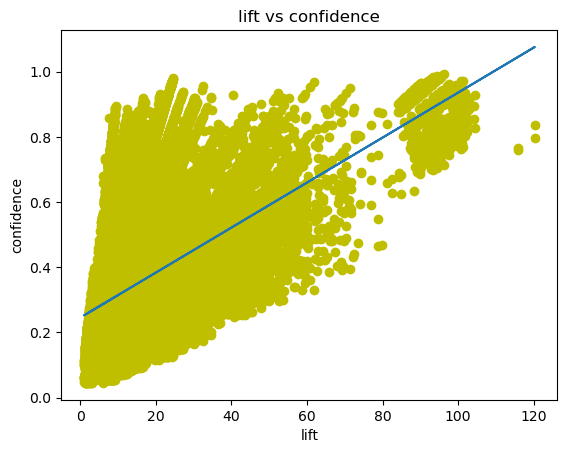

In [30]:
plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

## Apriori Algorithm

Vamos a realizar el mismo procedimiento que con el algoritmo FP Growth pero ahora utilizando la regla Apriori. Este notebook se hará con las dos metodologías para comprarar el tiempo de ejecución.

In [31]:
trans_encoder_matrix.shape

(17549, 3669)

In [32]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(trans_encoder_matrix, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))

Computed Apriori!
Apriori Execution took: 983.8566098213196 seconds


__Observamos que Apriori le lleva más tiempo que FP Growth.__

### Soporte

In [33]:
apriori_matrix.head().sort_values(by='support', ascending=False)

,support,itemsets,number_of_items
4,0.012365,(10 COLOUR SPACEBOY PEN),1
2,0.012251,( SET 2 TEA TOWELS I LOVE LONDON ),1
1,0.005926,( DOLLY GIRL BEAKER),1
0,0.005698,( 50'S CHRISTMAS GIFT BAG LARGE),1
3,0.005698,( SPACEBOY BABY GIFT SET),1


La mayoría de las relaciones es de conjuntos de dos productos

In [34]:
apriori_matrix.number_of_items.value_counts()

2    1904
1    1193
3    1008
4     474
5      92
6       5
Name: number_of_items, dtype: int64

### Lift

In [35]:
apriori_rule_lift = compute_association_rule(apriori_matrix)

In [36]:
apriori_rule_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(12 PENCILS SMALL TUBE RED RETROSPOT),(12 PENCIL SMALL TUBE WOODLAND),0.016468,0.014531,0.005869,0.356401,24.527403,0.005630,1.531186
1,(12 PENCIL SMALL TUBE WOODLAND),(12 PENCILS SMALL TUBE RED RETROSPOT),0.014531,0.016468,0.005869,0.403922,24.527403,0.005630,1.650004
2,(12 PENCILS SMALL TUBE RED RETROSPOT),(12 PENCILS SMALL TUBE SKULL),0.016468,0.015784,0.006553,0.397924,25.209986,0.006293,1.634703
3,(12 PENCILS SMALL TUBE SKULL),(12 PENCILS SMALL TUBE RED RETROSPOT),0.015784,0.016468,0.006553,0.415162,25.209986,0.006293,1.681718
4,(12 PENCILS TALL TUBE SKULLS),(12 PENCILS TALL TUBE RED RETROSPOT),0.012080,0.012023,0.005470,0.452830,37.662166,0.005325,1.805612


In [37]:
result_apriori_rule_lift = apriori_rule_lift.copy()
result_apriori_rule_lift = pd.DataFrame(result_apriori_rule_lift)

result_apriori_rule_lift["antecedents"] = result_apriori_rule_lift["antecedents"].apply(lambda x: ",".join(x))
result_apriori_rule_lift["consequents"] = result_apriori_rule_lift["consequents"].apply(lambda x: ",".join(x))

Observamos los mismos productos que se le recomendaría si el usuario agregara el producto `12 PENCILS SMALL TUBE RED RETROSPOT` para ambos algoritmos.

In [38]:
result_apriori_rule_lift.loc[result_apriori_rule_lift.antecedents=='12 PENCILS SMALL TUBE RED RETROSPOT'
                        ].sort_values(by=['lift'], ascending=[False]).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,0.016468,0.015784,0.006553,0.397924,25.209986,0.006293,1.634703
0,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCIL SMALL TUBE WOODLAND,0.016468,0.014531,0.005869,0.356401,24.527403,0.005630,1.531186


### Confidence

In [48]:
apripri_rule_conf = compute_association_rule(apriori_matrix, metric="confidence", min_thresh=0.05)
apripri_rule_conf.shape

(19522, 9)

In [49]:
result_apriori_rule_conf = apripri_rule_conf.copy()
result_apriori_rule_conf = pd.DataFrame(result_apriori_rule_conf)

result_apriori_rule_conf["antecedents"] = result_apriori_rule_conf["antecedents"].apply(lambda x: ",".join(x))
result_apriori_rule_conf["consequents"] = result_apriori_rule_conf["consequents"].apply(lambda x: ",".join(x))

In [50]:
result_apriori_rule_conf.head(2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCIL SMALL TUBE WOODLAND,0.016468,0.014531,0.005869,0.356401,24.527403,0.00563,1.531186
1,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,0.014531,0.016468,0.005869,0.403922,24.527403,0.00563,1.650004


In [51]:
result_apriori_rule_conf.sort_values(by=['antecedents','confidence'], ascending=[True,False]).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,0.014531,0.016468,0.005869,0.403922,24.527403,0.005630,1.650004
2,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,0.016468,0.015784,0.006553,0.397924,25.209986,0.006293,1.634703
0,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCIL SMALL TUBE WOODLAND,0.016468,0.014531,0.005869,0.356401,24.527403,0.005630,1.531186
3,12 PENCILS SMALL TUBE SKULL,12 PENCILS SMALL TUBE RED RETROSPOT,0.015784,0.016468,0.006553,0.415162,25.209986,0.006293,1.681718
5,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,0.012023,0.012080,0.005470,0.454976,37.662166,0.005325,1.812618


In [43]:
result_apriori_rule_conf.loc[result_apriori_rule_conf.antecedents=='12 PENCILS SMALL TUBE RED RETROSPOT'
                        ].sort_values(by=['lift'], ascending=[False]).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,0.016468,0.015784,0.006553,0.397924,25.209986,0.006293,1.634703
0,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCIL SMALL TUBE WOODLAND,0.016468,0.014531,0.005869,0.356401,24.527403,0.005630,1.531186


En esta gráfica podemos observar que existe cierta asociación entre algunos productos pero muchos se encuentran cercanos al cero.

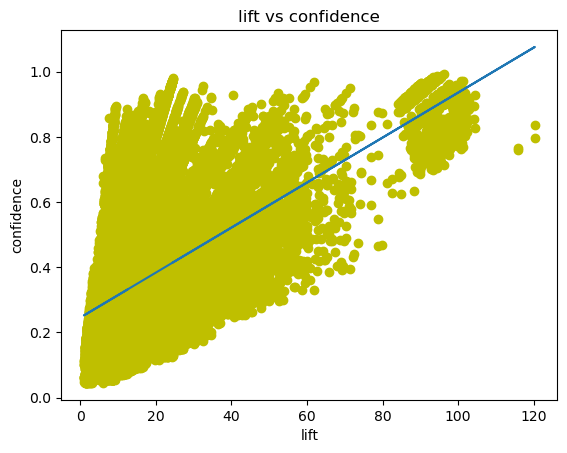

In [44]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

## Tiempo de ejecución

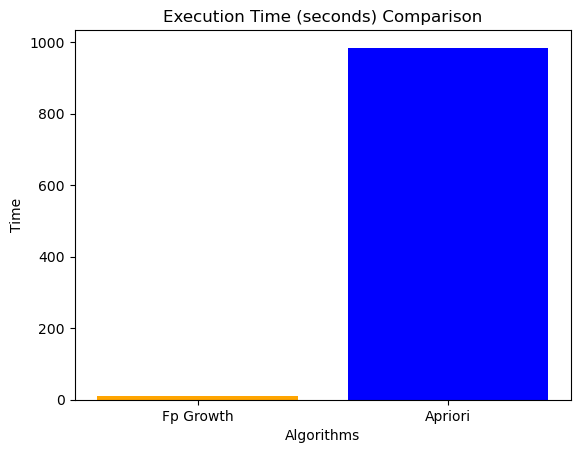

In [53]:
algo1 = ['Fp Growth', fp_growth_exec_time]
algo2 = ['Apriori', apriori_exec_time]

compare_time_exec(algo1, algo2)

Tal como es de esperar el algoritmo de FP Growth es computacionalemente mucho más rápido y los resultados son los mismos. 

In [54]:
print('Execution time FP Growth:', fp_growth_exec_time, 
      '\n'
      'Execution time Apriori:',   apriori_exec_time,
      '\n',
      round(fp_growth_exec_time/apriori_exec_time*100,0))

Execution time FP Growth: 10.381493091583252 
Execution time Apriori: 983.8566098213196 
 1.0
